### Training 

The srbm is trained with data similar to the one used by Finnegan et al. (2015)

/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



Please run the data generation file if not done so yet!!

Number of seed patterns:                      5
Number of prototypes per seed patterns        10
Number of prototypes total:                   50
Number of variations per prototype            10
Number of patterns total                      500
Number of input neurons (stimulus length):    100
Number of hidden neurons:                     500
Number of class neurons:                      0
Number of class neurons per class:            0
Matched
[[0.    0.    0.    0.    0.   ]
 [0.09  0.    0.    0.    0.   ]
 [0.05  0.045 0.    0.    0.   ]
 [0.03  0.03  0.035 0.    0.   ]
 [0.    0.005 0.01  0.015 0.   ]]


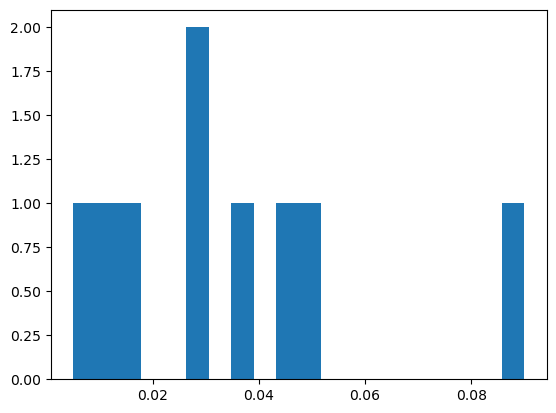

Data loaded from data/data_uniform_variations_100.pkl

Variations per prototype in train set after train-test-split: 9
Variations per prototype in test set after train-test-split:  1

Each group consists of 45 randomized patterns. 
The patterns for the first group consist of the 9 variations of the first of the 10 prototypes 
that were generated for each of the 5 seed patterns. 
Practically, that means that the first group consists of the 9 variations of the first prototype 
generated of the first seed pattern + the 9 variations of the first prototype generated of the second 
seed pattern, etc., making 45 patterns in total. 
The second group consists of the 9 variations of the second prototype generated of the first seed 
pattern + the 9 variations of the second prototype generated of the second seed pattern, etc.


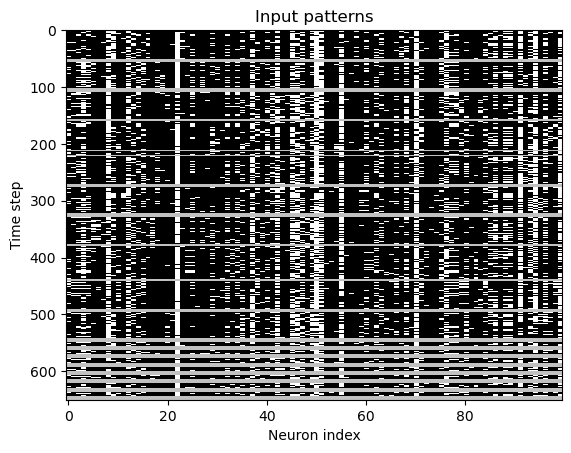

The input patterns are shown above. 
After each group of 45 patterns, test patterns for each prototype are shown. 
In the end all test patterns are shown. 



In [1]:
import numpy as np 
from tools.srbm import *           # !!! Importing the experimental SRBM model !!!
from tools.functions import *
import matplotlib.pyplot as plt
from brian2tools import *
from tools.parameters import *
from generate_data import *

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]

# Some parameters for training the SRBM - the others are in paramters_main.py

T = dcmt*t_ref
init_delay=dcmt*t_ref
delay=0*ms

n_samples = 1000

# Loading the data
data_finnegan = load_data("data_uniform_variations_100")

train_test_data = train_test_split_finnegan(data_finnegan, 0.9)

print("\nVariations per prototype in train set after train-test-split: " + str(len(train_test_data[0][0])))
print("Variations per prototype in test set after train-test-split:  " + str(len(train_test_data[1][0])))

off_time = 1 # How many frames should be after a test pattern before the next test pattern is presented?

# Create the Ids. Test patterns are not randomized!
Ids, time_test_on, time_test_off = create_finnegan_Ids(train_test_data, off_time = 1)

print("\nEach group consists of " + str(len(train_test_data[0][0]) * n_seed_patterns) + " randomized patterns. \n" +
      "The patterns for the first group consist of the " + str(len(train_test_data[0][0])) + " variations of " + 
      "the first of the " + str(n_prototype_per_seed) +  " prototypes \nthat were generated for each of the " + str(n_seed_patterns) + " seed patterns. \n" + 
      "Practically, that means that the first group consists of the 9 variations of the first prototype \n" + 
      "generated of the first seed pattern + the 9 variations of the first prototype generated of the second \n" + 
      "seed pattern, etc., making " + str(len(train_test_data[0][0]) * n_seed_patterns) + " patterns in total. \n" + 
      "The second group consists of the 9 variations of the second prototype generated of the first seed \n" + 
      "pattern + the 9 variations of the second prototype generated of the second seed pattern, etc.")

fig, ax = plt.subplots()
plt.imshow(Ids, cmap='gray', aspect='auto', interpolation= "None")
plt.xlabel("Neuron index")
plt.ylabel("Time step")
plt.title("Input patterns")
plt.show()
print("The input patterns are shown above. \n" +
      "After each group of " + str(len(train_test_data[0][0]) * n_seed_patterns) + " patterns, test patterns for each prototype are shown. \n" + 
      "In the end all test patterns are shown. \n")



In [2]:
## shorten ids for trials!
#Ids = Ids[0:110] 
#Ids = np.repeat(Ids[1], 30).reshape(200, 30).T

In [3]:
# Create the parameters for the SRBM
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)

# Create timepoints for classificaiton
# One timepoint for each input pattern. Starts with timepoint 1
timepoints, t_sim, time_points_dict = create_timepoints(Ids, init_delay, delay, T)

# Calculate simulation time for accurate neural growth
sim_time = (t_sim / (dcmt*t_ref))

In [4]:
# SRBM main function
# leak helper is sensistivity ov average
print("Starting the SRBM simulation...")
out = main(W, b_v, b_c, b_h, Id = Ids, sim_time = sim_time, t_sim = t_sim, dorun = True, n_classes = 5,
           monitors = True, display=False, # set display to false if no lables are used 
           # Ageing parameters:
           p_target = 1e-10 , sparsity_cost = 0.1, # sparsity cost in learning equation
           leak_helper = 10, # how reactive is the helper neuron that determines the average firing rate of the hidden neurons (for the sparsity cost)
           age_neurons = True, # Should the network age in any way?
           age_leak = False, # Should the leak conductance depend on the age of the neuron?
           age_threshold= True, # Should the threshold depend on the age of the neuron?
           threshold_ageing_degree = 0.5, # How much should the threshold depend on the age of the neuron?
           set_connectivity = True, # Should the connectivity be controlled?
           connectivity_born=0.01, connectivity_mature=0.05, # How connected are the neurons at the beginning and at the end of their life? If the same number is given, the connectivity is constant.
           neurogenesis = True, # Should new neurons be born?
           generations = 4, # How often are neurons reborn? Only matters if tunrover is True!
           turnover=True, # Should neurons die?
           prop_born= 0.1, # How many neurons are yet to be born thoughout the whole simulation? Only matters if turnover is True!
           gompertz=[0, 1], # horizontal shift, growth rate
           apt_wt_str = 0.25, apt_diff = 0.6, apt_age = 0.15, # weight of weight strength and differntiation and age on p_aptosis
           n_percent_aptosis = 0.1, # percentage of neurons in aptosis ranking 
           ) 
locals().update(out)

Starting the SRBM simulation...
ageing factor:  0.20481310803891467


INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_7p3587em/var
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_7p3587em/var/folders
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_7p3587em/var/folders/07
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_7p3587em/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_7p3587em/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_7p3587em/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_7p3587em
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -arch arm64 -fPIC -O2 -isystem /opt/homebrew

Starting simulation at t=0. s for a duration of 78.12 s
2.1733 s (2%) simulated in 10s, estimated 5m 49s remaining.
4.3921 s (5%) simulated in 20s, estimated 5m 36s remaining.
6.6133 s (8%) simulated in 30s, estimated 5m 24s remaining.
8.7253 s (11%) simulated in 40s, estimated 5m 18s remaining.
10.9261 s (13%) simulated in 50s, estimated 5m 8s remaining.
13.1185 s (16%) simulated in 1m 0s, estimated 4m 57s remaining.
15.3768 s (19%) simulated in 1m 10s, estimated 4m 46s remaining.
17.4901 s (22%) simulated in 1m 20s, estimated 4m 37s remaining.
19.6561 s (25%) simulated in 1m 30s, estimated 4m 28s remaining.
21.9013 s (28%) simulated in 1m 40s, estimated 4m 17s remaining.
24.2017 s (30%) simulated in 1m 50s, estimated 4m 5s remaining.
26.2525 s (33%) simulated in 2m 0s, estimated 3m 57s remaining.
28.6213 s (36%) simulated in 2m 10s, estimated 3m 45s remaining.
30.9589 s (39%) simulated in 2m 20s, estimated 3m 33s remaining.
33.1165 s (42%) simulated in 2m 30s, estimated 3m 24s remain

In [5]:
Mh, Mv, Mc= out['Mh'], out['Mv'], out['Mc']
sMhh_age = out["sMhh_age"]
sMhh_av_act = out["sMhh_av_act"]
sMh_age = out["sMh_age"]
sMh_v = out["sMh_v"]
sMhh_age = out["sMhh_age"]
sMh_q = out["sMh_q"]
weights = out["weights"]
connections = out["connections"]
average_weigth_strenght = out["av_wt_str"]
differenti = out["differentiat"]
check = out["check"]

In [6]:
""" import pandas as pd
df = pd.DataFrame(weights)
df.to_csv("weights.csv") """

' import pandas as pd\ndf = pd.DataFrame(weights)\ndf.to_csv("weights.csv") '

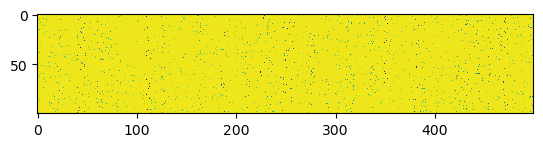

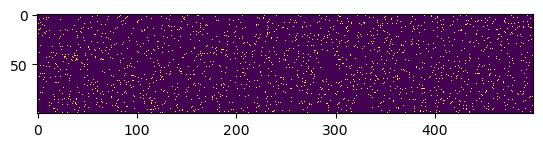

In [7]:
plt.imshow(weights[10].reshape(500, 100).T, interpolation="None")
plt.show()  
plt.imshow(connections[9].reshape(500, 100).T, interpolation="None")
plt.show()

WARNING    /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/brian2tools/plotting/data.py:59: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axes.plot(spike_times/time_unit, spike_indices, '.', **kwds)
 [py.warnings]
  axes.plot(spike_times/time_unit, spike_indices, '.', **kwds)



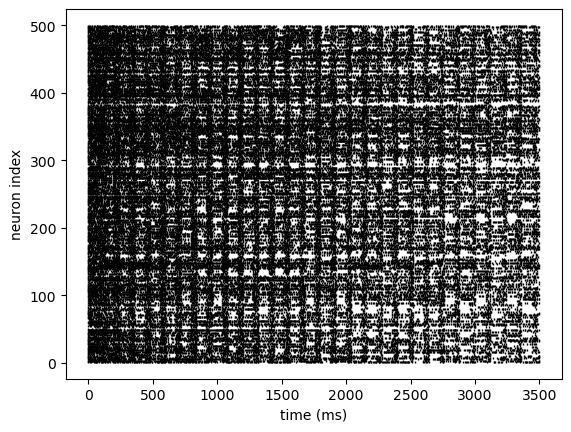

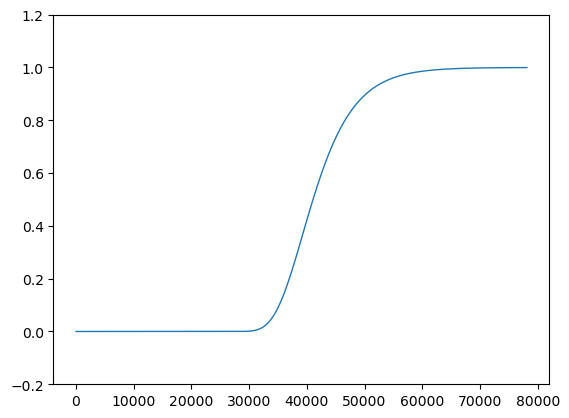

In [8]:
t_start = 1
t_stop = 30
precision = 0
idx_start = np.where(np.round(Mh.t, precision) == np.round(time_points_dict["T"+str(t_start)+"_s"]/second, precision))[0][0]
idx_stop = np.where(np.round(Mh.t, precision) == np.round(time_points_dict["T"+str(t_stop)+"_e"]/second-0.01, precision))[0][0]
plot_raster(Mh.i[idx_start:idx_stop], Mh.t[idx_start:idx_stop], markersize=2,marker='|', color='k', mew=1)
plt.show()


# Some plots - use only with small trial sets!
n_neurons = 1
for i in np.arange(n_neurons):
    plt.plot(sMh_age.t/ms, sMh_age.age[i], linewidth=1) 
plt.ylim(-0.2, 1.2)

plt.show()


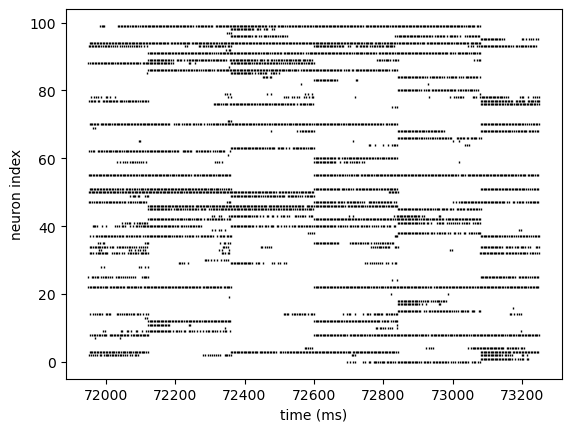

In [9]:
t_start = 600
t_stop = 610
precision = 1
idx_start = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_start)+"_s"]/second, precision))[0][0]
idx_stop = np.where(np.round(Mv.t, precision) == np.round(time_points_dict["T"+str(t_stop)+"_e"]/second-0.01, precision))[0][0]
plot_raster(Mv.i[idx_start:idx_stop], Mv.t[idx_start:idx_stop], markersize=2,marker='|', color='k', mew=1)
plt.show()

In [10]:
""" n_neurons = 3
for i in np.arange(n_neurons):
    plt.plot(sMhh_av_act.t/ms, sMh_v.v[i], label='Neuron ' + str(i), linewidth=0.5)
plt.legend(loc=2, prop={'size': 8})

plt.show()
 """

" n_neurons = 3\nfor i in np.arange(n_neurons):\n    plt.plot(sMhh_av_act.t/ms, sMh_v.v[i], label='Neuron ' + str(i), linewidth=0.5)\nplt.legend(loc=2, prop={'size': 8})\n\nplt.show()\n "

In [11]:
""" plt.plot(sMhh_av_act.t/ms, sMhh_av_act.q[0], label='Neuron ' + str(i), linewidth=0.5)
#plt.ylim(0, 0.01)
#plt.legend(loc=2, prop={'size': 8})

plt.show()



#plot_raster(Mh.i, Mh.t, markersize=2,marker='|', color='k', mew=1)
#plt.show() """

" plt.plot(sMhh_av_act.t/ms, sMhh_av_act.q[0], label='Neuron ' + str(i), linewidth=0.5)\n#plt.ylim(0, 0.01)\n#plt.legend(loc=2, prop={'size': 8})\n\nplt.show()\n\n\n\n#plot_raster(Mh.i, Mh.t, markersize=2,marker='|', color='k', mew=1)\n#plt.show() "

In [12]:
# Prepare weights and biases
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

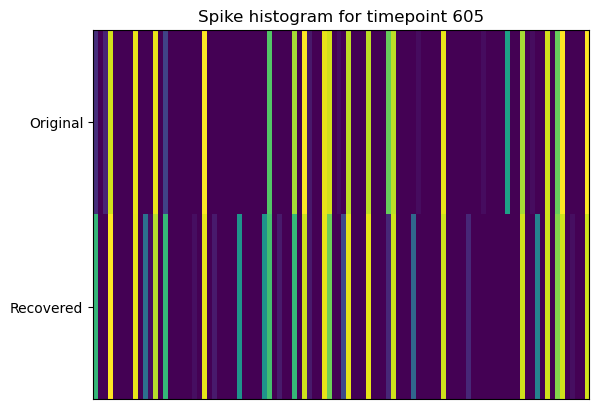

In [13]:
timepoint = 605 # for which timepoint should the spike histogram be plotted?

t_start_stimulus = time_points_dict["T"+ str(timepoint)+"_s"]
t_stop_stimulus = time_points_dict["T"+ str(timepoint)+"_e"]
t_start_recover = time_points_dict["T"+ str(timepoint+1)+"_s"]
t_stop_recover = time_points_dict["T"+ str(timepoint+off_time)+"_e"]
orig = spike_histogram(Mv, t_start=t_start_stimulus, t_stop=t_stop_stimulus).T[1]
recover = spike_histogram(Mv, t_start=t_start_recover+0.01*second, t_stop=t_stop_recover).T[1]

fig, ax = plt.subplots()
plt.imshow(np.row_stack((normalizer(orig), normalizer(recover))), aspect='auto', interpolation= "None")
plt.yticks(np.linspace(0, 1, 2),["Original", "Recovered"])
plt.title("Spike histogram for timepoint " + str(timepoint))
ax.set_xticks([])
plt.show()

In [14]:
# Function to save the output of the SRBM simulation
def save_output(unique = "", date = "", path = "output/"):
    '''Saves the output of the SRBM simulation in a pickle file.'''
    import pickle
    k_v, v_v = zip(*Mv.spike_trains().items())
    k_h, v_h = zip(*Mh.spike_trains().items())
    output = {"Mv": {"i":np.array(Mv.i), "t":np.array(Mv.t), 
                     "k": k_v, "v": v_v}, 
              "Mh": {"i":np.array(Mh.i), "t":np.array(Mh.t), 
                     "k": k_h, "v": v_h},
              "time_test_on":time_test_on,
              "time_test_off":time_test_off,
              "Ids":Ids,
              "timepoints":timepoints,
              "t_sim":t_sim,
              "time_points_dict":time_points_dict,
              "W":W,
              "b_v":b_v,
              "b_c":b_c,
              "b_h":b_h,
              "mB":mB,
              "Wvh":Wvh,
              "Wch":Wch,
              "mBv":mBv,
              "mBh":mBh,
              "sim_time":sim_time,
              "N_v":N_v,
              "N_c":N_c,
              "N_h":N_h,
              "beta_parameter":beta_parameter,
              "tau_rec":tau_rec,
              "dcmt":dcmt,
              "off_time":off_time,
              "n_seed_patterns": n_seed_patterns,
              "n_prototype_per_seed": n_prototype_per_seed,
              "n_variations_per_prototype": n_variations_per_prototype, 
              "after_split_n_per_prototype_train": len(train_test_data[0][0]), 
              "after_split_n_per_prototype_test": len(train_test_data[1][0])}                                 
    with open(path+unique+date+'.pkl', 'wb') as handle: # Python 3:
        pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Output saved as output/"+unique+date+".pkl")

In [15]:
# Save the output to open in the evaluation notebook
save_output(unique = "1-sparse_age_01_born_threshold_turnover", date = "", path = "output_final/")

Output saved as output/3-sparse_age_01_born_threshold.pkl
